In [19]:
import numpy as np
import pandas as pd
from glob import glob
import json
import re
import matplotlib.pyplot as plt

In [20]:
P={
  "A1": [[1,0],
        [0,1]],
  "B1": [[-0.559,0.03],
        [0.852,0.912]],
  "D1": [[-0.548,0.281],
        [0.281,0.348]],
  "X1": [-0.289,-0.471],
  "Y1": [0.396,2.631],
  "A2": [[1,0],
        [0,1]],
  "B2": [[1.048,0.156],
        [-1.337,-1.145]],
  "D2": [[-0.333,0.051],
        [0.051,1.08]],
  "X2": [0.461,-0.791],
  "Y2": [1.201,0.149],
}
    
A1 = P['A1']
B1 = P['B1']
D1 = P['D1']
X1 = P['X1']
Y1 = P['Y1']

A2 = P['A2']
B2 = P['B2']
D2 = P['D2']
X2 = P['X2']
Y2 = P['Y2']

def f1(x,y):
    return (1/2)*(x-X1).T @ A1 @ (x-X1) \
               + (x-X1).T @ B1 @ (y-Y1) \
         + (1/2)*(y-Y1).T @ D1 @ (y-Y1)


def f2(x,y):
    return (1/2)*(y-Y2).T @ A2 @ (y-Y2) \
               + (y-Y2).T @ B2 @ (x-X2) \
         + (1/2)*(x-X2).T @ D2 @ (x-X2)

def g1(x,y):
    return A1 @ (x-X1) + B1 @ (y-Y1)  # =0

def g12(x,y):
    return np.transpose(B1) @ (x-X1) + D1 @ (y-Y1) 

def g2(x,y):
    return A2 @ (y-Y2) + B2 @ (x-X2)  # =0


In [21]:
# theoretical prediction for lr=0 case
lr1 = 0.1
lr2 = 0.1
T = 1000
x = np.zeros((T,2))
y = np.zeros((T,2))
for t in range(T-1):
    x[t+1] = x[t]-lr1*g1(x[t],y[t])
    y[t+1] = y[t]-lr2*g2(x[t],y[t])
x_nash = x[-1]
y_nash = y[-1]

In [22]:
# theoretical prediction for lr=infinity (lr=-1) case
lr1 = 0.1
lr2 = 0.1
dx = 0.1
T = 1000
K = 100
x = np.zeros((T,2))
y = np.zeros((T,2))
for t in range(T-1):
    dx = np.random.randn(2)
    dx /= np.sqrt(sum(dx**2))
    dx *= 0.1
    
    yp = y[t]
    for k in range(K):
        yp = yp-lr2*g2(x[t]+dx, yp)
        
    yn = y[t]
    for k in range(K):
        yn = yn-lr2*g2(x[t]-dx, yn)
        
    grad = dx*(f1(x[t]+dx,yp) - f1(x[t]-dx,yn))/0.1
    
    x[t+1] = x[t]-lr1*grad # NOT g1
    
    y[t+1] = y[t]-lr2*g2(x[t],y[t])
    
x_stack = x[-1]
y_stack = y[-1]

In [23]:
directories = ["data_wqr", "data_ckx"]
dir =  "data\data_wqr" # CHANGE THE DIRECTORY NAME HERE
FILES = glob(dir + '\\data-*.json')

In [24]:
data_dict  = dict(trial=[],  lr=[],  t=[],  x1=[],  x2=[],  y1=[],  y2=[], f1=[])
for file in FILES:
    with open(file) as f:
        result = re.search(r".*\\data-([-]*[.\d]*[\d]*)-", file)
        lr = result.groups(1)[0]
        data = json.load(f)
        L = len(data[1:])
        for i,var in enumerate(data[0]):
            data_np = np.array(data[1:])
            data_dict[var] += list(data_np[:,i])
        data_dict['trial'] += [file]*L
        data_dict['lr'] += [float(lr)]*L
        
df = pd.DataFrame(data_dict)
# df=df[df.t>40*25]
df.groupby('trial').median()

,lr,t,x1,x2,y1,y2,f1
trial,,,,,,,


In [17]:
# df.groupby('trial').get_group('data2\data-0.003--11.json').hist('x2')

<AxesSubplot:xlabel='lr', ylabel='x1'>

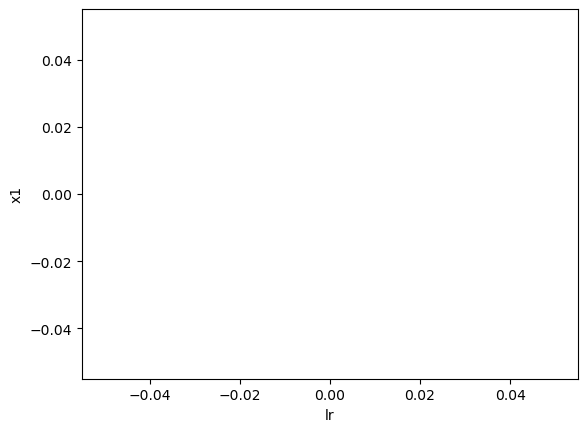

In [18]:
df.groupby('trial').median().plot.scatter('lr', 'x1')

<AxesSubplot:xlabel='lr', ylabel='x2'>

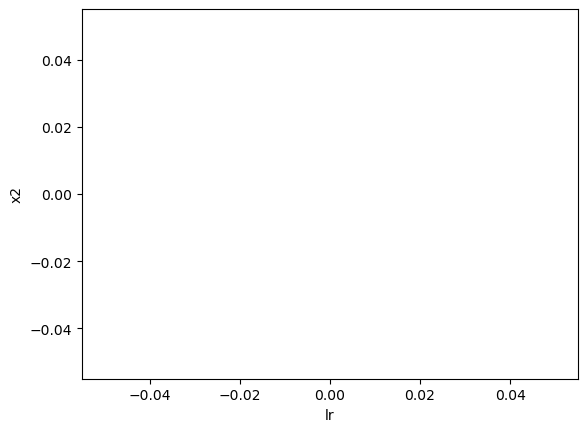

In [9]:
df.groupby('trial').median().plot.scatter('lr', 'x2')

In [10]:
# why different number of data points
# data 1 has twice the data points but half the total sum -- wrong
# data 1 relatively better than data 2
df.f1.count(), df.f1.sum(), df.f1.mean()
# run this cell alone gives different results. how does jupiter notebook work?
# something changes the df below

(0, 0.0, nan)

In [11]:
x_nash, x_stack

(array([0.24530231, 0.23872283]), array([-0.49569948,  0.19613466]))

In [12]:
x1 = df.groupby('trial').get_group(dir + 'data-0.03-1-1.json').x1
x2 = df.groupby('trial').get_group(dir + 'data-0.03-1-1.json').x2
plt.plot(x1,x2)
plt.plot(np.median(x1),np.median(x2),'o')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.savefig("img/" + dir + "-cursor")

KeyError: 'datadata-0.03-1-1.json'

(-1.0, 1.0)

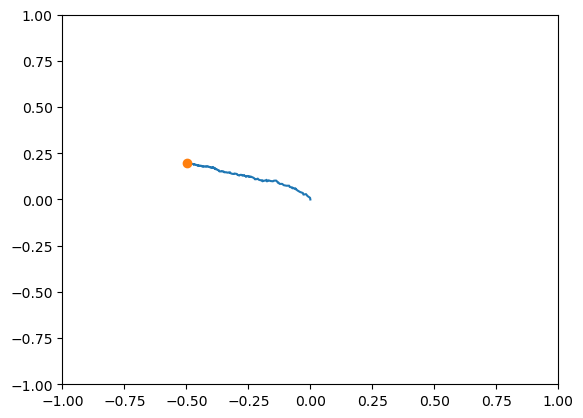

In [13]:
plt.plot(x[:,0],x[:,1])
plt.plot(x[-1,0],x[-1,1],'o')
plt.xlim([-1,1])
plt.ylim([-1,1])

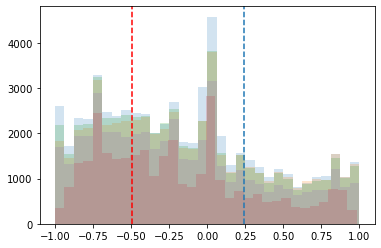

In [ ]:

plt.hist(df.groupby('lr').get_group(0).x1,bins=32,alpha=0.2)
plt.hist(df.groupby('lr').get_group(0.003).x1,bins=32,alpha=0.2)
plt.hist(df.groupby('lr').get_group(0.03).x1,bins=32,alpha=0.2)
plt.hist(df.groupby('lr').get_group(0.3).x1,bins=32,alpha=0.2)
plt.hist(df.groupby('lr').get_group(-1).x1,bins=32,alpha=0.2)
plt.gca().axvline(x_nash[0],ls='--')
plt.gca().axvline(x_stack[0],ls='--',color='r')
# why nash and stack stays the same in data 1 and data 2 xxx
# why nash and stack have different x values? is nash wrong?
plt.savefig("img/data3-x1")
pass

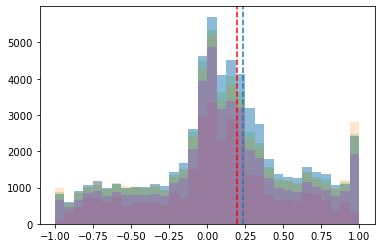

In [ ]:

plt.hist(df.groupby('lr').get_group(0).x2,bins=32,alpha=0.5)
plt.hist(df.groupby('lr').get_group(0.003).x2,bins=32,alpha=0.2)
plt.hist(df.groupby('lr').get_group(0.03).x2,bins=32,alpha=0.2)
plt.hist(df.groupby('lr').get_group(0.3).x2,bins=32,alpha=0.2)
plt.hist(df.groupby('lr').get_group(-1).x2,bins=32,alpha=0.5)
plt.gca().axvline(x_stack[1],ls='--',color='r')
plt.gca().axvline(x_nash[1],ls='--')
plt.savefig("img/data3-x2")
pass

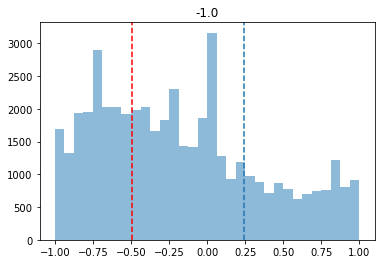

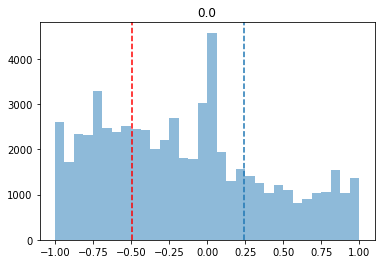

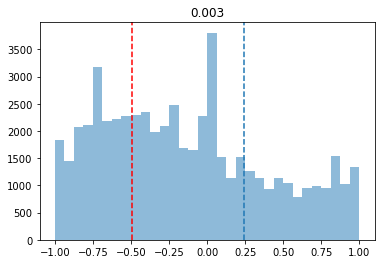

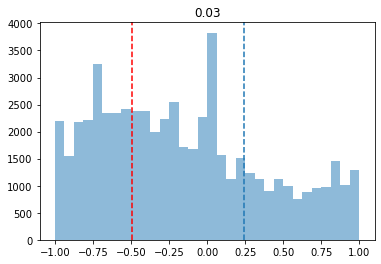

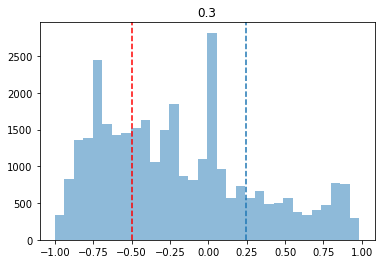

In [ ]:
for lr in df.lr.unique():
    plt.figure()
    plt.hist(df.groupby('lr').get_group(lr).x1,bins=32,alpha=0.5)
    plt.gca().axvline(x_nash[0],ls='--')
    plt.gca().axvline(x_stack[0],ls='--',color='r')
    plt.title(lr)

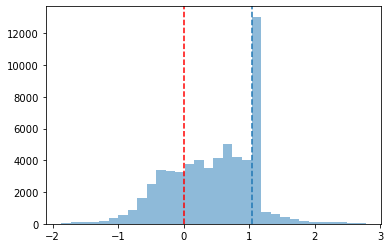

In [ ]:
plt.hist(df.groupby('lr').get_group(0).y2,bins=32,alpha=0.5)
plt.gca().axvline(y_nash[1],ls='--') # 
plt.gca().axvline(y_stack[1],ls='--',color='r') # one first one follows

In [ ]:
x_nash,y_nash

(array([0.24530231, 0.23872283]), array([1.26641441, 1.03964483]))

In [ ]:
x_stack,y_stack

(array([-0.49569932,  0.19613465]), array([2.04962776e+00, 1.62300248e-04]))

In [ ]:
#Nash conditions

In [ ]:
g1(x_nash, y_nash)

array([0.00000000e+00, 1.11022302e-16])

In [ ]:
g2(x_nash, y_nash)

array([7.21644966e-16, 1.11022302e-16])

In [ ]:
#Stackelberg conditions:

In [ ]:
g1(x_stack,y_stack)-np.linalg.solve(A2,B2).T@g12(x_stack, y_stack)

array([3.31326889e-05, 8.48528077e-06])

In [ ]:
g2(x_stack,y_stack)

array([-1.19752775e-07,  1.20089209e-07])

In [ ]:
f1(x_nash, y_nash)

-0.5507653036665989

In [ ]:
f1(x_stack, y_stack)

-0.9768847636887588

In [ ]:
df=df[df.t>40*15]